# NBA Viewer Prediction

This is the work and thoughts while building our model to predict viewership for the NBA.

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import numpy as np 
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Read Data

In [4]:
game_data = pd.read_csv("game_data.csv")
player_data = pd.read_csv("player_data.csv")
training_data = pd.read_csv("training_set.csv", parse_dates = ['Game_Date'])

In [5]:
training_data.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Country,Rounded Viewers
0,2016-17,21600001,2016-10-25,NYK,CLE,C113,18
1,2016-17,21600001,2016-10-25,NYK,CLE,C193,1
2,2016-17,21600001,2016-10-25,NYK,CLE,C126,4
3,2016-17,21600001,2016-10-25,NYK,CLE,C163,11
4,2016-17,21600001,2016-10-25,NYK,CLE,C73,3


In [6]:
training_data.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team', 'Country',
       'Rounded Viewers'],
      dtype='object')

In [7]:
training_data.dtypes

Season                     object
Game_ID                     int64
Game_Date          datetime64[ns]
Away_Team                  object
Home_Team                  object
Country                    object
Rounded Viewers             int64
dtype: object

In [8]:
training_data.set_index("Game_ID", inplace = True)

First do some feature engineering on the dates, get the day of the week, and see average viewers on each day

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


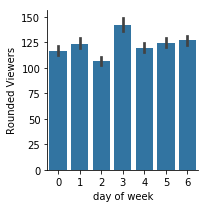

In [9]:
training_data['day of week'] = training_data.Game_Date.dt.dayofweek
g = sns.FacetGrid(training_data)
g.map(sns.barplot, 'day of week',  'Rounded Viewers')

Looks like Thursday has the higehst number of viewers, something to take note of would be the possible variables that make Thursday have the highest number of viewers

Next make sure our categorical variables are actually categorical

In [10]:
training_data.dtypes

Season                     object
Game_Date          datetime64[ns]
Away_Team                  object
Home_Team                  object
Country                    object
Rounded Viewers             int64
day of week                 int64
dtype: object

In [11]:
training_data['Away_Team'] = training_data['Away_Team'].astype('category').cat.as_ordered()
training_data['Home_Team'] = training_data['Home_Team'].astype('category').cat.as_ordered()
training_data.dtypes

Season                     object
Game_Date          datetime64[ns]
Away_Team                category
Home_Team                category
Country                    object
Rounded Viewers             int64
day of week                 int64
dtype: object

Add Weekend Data

In [12]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 0)

In [13]:
training_data.Away_Team.cat.categories

Index(['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
       'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
       'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'],
      dtype='object')

In [14]:
training_data.Away_Team = training_data.Away_Team.cat.codes
training_data.Home_Team = training_data.Home_Team.cat.codes

In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [16]:
training_data.head()

,Season,Game_Date,Away_Team,Home_Team,Country,Rounded Viewers,day of week,weekend
Game_ID,,,,,,,,
21600001,2016-17,2016-10-25,19,5,C113,18,1,0
21600001,2016-17,2016-10-25,19,5,C193,1,1,0
21600001,2016-17,2016-10-25,19,5,C126,4,1,0
21600001,2016-17,2016-10-25,19,5,C163,11,1,0
21600001,2016-17,2016-10-25,19,5,C73,3,1,0


Lastly, we will only look at total viewers for now as it is what the test dataset is evalulated on. We may come back to look at countries later

In [17]:
training_data['Total_Views'] = training_data.groupby("Game_ID")["Rounded Viewers"].sum()

In [18]:
training_data.drop(['Rounded Viewers', 'Country'], inplace = True, axis = 1)
training_data.drop_duplicates(inplace = True)

Next make sure day of week and season are categorical. It shouldn't matter too much for random forests but it is good to be safe

In [19]:
training_data['Season'] = training_data['Season'].astype('category').cat.as_ordered()
training_data['day of week'] = training_data['day of week'].astype('category').cat.as_ordered()
training_data.dtypes

Season               category
Game_Date      datetime64[ns]
Away_Team                int8
Home_Team                int8
day of week          category
weekend                 int32
Total_Views             int64
dtype: object

In [20]:
training_data.Season = training_data.Season.cat.codes
training_data['day of week']= training_data['day of week'].cat.codes

In [21]:
print(training_data.head())

          Season  Game_Date  Away_Team  Home_Team  day of week  weekend  \
Game_ID                                                                   
21600001       0 2016-10-25         19          5            1        0   
21600003       0 2016-10-25         26          9            1        0   
21600002       0 2016-10-25         28         24            1        0   
21600006       0 2016-10-26          1          2            2        0   
21600008       0 2016-10-26          3         16            2        0   

          Total_Views  
Game_ID                
21600001        57691  
21600003        60428  
21600002        40740  
21600006        23947  
21600008        12046  


In [22]:
def mape(x, y): return np.mean(np.abs((x - y) / y)) * 100

def randomforest(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    randomforest = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
    randomforest.fit(train_X, train_y)
    res = [mape(randomforest.predict(train_X), train_y), mape(randomforest.predict(val_X), val_y), 
          randomforest.score(train_X, train_y), randomforest.score(val_X, val_y)]
    if hasattr(randomforest, 'oob_score_'): res.append(randomforest.oob_score_)
    print(res)

    

In [24]:
%time randomforest(training_data)

[17.975636508578532, 46.839279476123991, 0.91504325895629224, 0.44232068786947332, 0.42132830451346381]
Wall time: 873 ms


With these limited columns, our data is definetly extremely overfitted. The Mape is only 18% for the training data, but 46% for the validation. The r^2 shows the same. We will add more variables to help combat this

All-Star Data

In [25]:
player_data['AllStar'] = np.where(player_data.ASG_Team != "None", 1, 0)
player_data.set_index('Game_ID', inplace = True)
allstar = player_data.groupby('Game_ID')['AllStar'].sum()
training_data['AllStar'] = allstar
del allstar

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


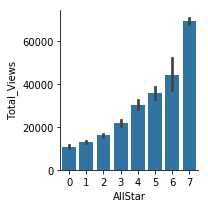

In [26]:
g = sns.FacetGrid(training_data)

g.map(sns.barplot, 'AllStar',  'Total_Views')

Clearly a decent relationship between number of all stars in a game and the total viewers

In [27]:
randomforest(training_data)

[16.706740503982282, 44.619336978187022, 0.92371974435928039, 0.51325910955319176, 0.48515813466993207]


Try adding population of cities to the teams

In [28]:
population_of_city = {'CLE': 2055612, 'NYK': 10153634, 'POR': 2424955,'UTA': 1186187, 'GSW': 4679166, 'SAS': 2429609, 'MIA':  6066387,
                     'ORL': 2441257, 'DAL': 7233323, 'IND': 2004230, 'BOS': 4794447, 'BKN': 10000000, 'TOR': 5928040, 'DET': 4297617,
                     'MIL': 1572482, 'MEM': 1342842, 'NOP': 1268883, 'DEN': 2853077, 'PHI': 6070500, 'OKC': 1373211, 'PHX': 4661537, 
                     'SAC': 2296418, 'HOU': 6772470, 'LAL': 13310447, 'ATL': 5789700, 'WAS': 6131977, 'CHI': 9512999, 'LAC': 13310446,
                     'CHA': 2474314, 'MIN': 3551036 }


game_data['Team_population'] = game_data['Team'].map(population_of_city)
game_data.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Team', 'Location',
       'Wins_Entering_Gm', 'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score',
       'Lead_Changes', 'Ties', 'Largest_Lead', 'Full_Timeouts',
       'Short_Timeouts', 'Qtr_4_Score', 'L2M_Score', 'Team_population'],
      dtype='object')

In [29]:
training_data['Total_population'] = game_data.groupby('Game_ID')['Team_population'].sum()

In [30]:
randomforest(training_data)

[17.312376046883347, 44.358626894099622, 0.91861155705946484, 0.50932267163469902, 0.44838105153684005]


not much of a change, may try to get rid of this later on

In [31]:
game_data.set_index('Game_ID', inplace = True)
training_data['Home_team_population']= game_data.loc[game_data['Location'] == 'H', ['Team_population']]

In [32]:
randomforest(training_data)

[17.065252221343805, 43.209059198604699, 0.91949657580865929, 0.51872133169976808, 0.45417798237447427]


Try one hot encoding on teams instead

In [33]:
training_data = pd.get_dummies(training_data, columns = ['Home_Team', 'Away_Team'])


In [34]:
randomforest(training_data)

[15.192791386560431, 38.373223603161549, 0.9257272720069375, 0.56207488764930502, 0.50065510915938338]


In [35]:
randomforest(training_data.drop(['Total_population', 'Home_team_population'], axis = 1))

[14.495771075775233, 38.147355439320187, 0.92765604459197115, 0.55428455937310539, 0.51448381071901472]


We will drop total and home team population for now as it seems to have no effect

In [36]:
training_data.drop(['Total_population', 'Home_team_population'], axis = 1, inplace = True)

Adding some information about first game/first week

In [37]:
game_data['Total_games'] = game_data[[ 'Wins_Entering_Gm', 'Losses_Entering_Gm']].sum(axis = 1)
game_data['First_game'] = np.where(game_data['Total_games'] == 0, 1, 0)
game_data['First_week'] = np.where(game_data['Total_games'] < 3, 1, 0)

In [38]:
training_data['First_game'] = game_data.loc[game_data['Location'] == 'H', ['First_game']]
training_data['First_week'] = game_data.loc[game_data['Location'] == 'H', ['First_week']]

In [39]:
randomforest(training_data)

[13.762692270145466, 35.295824194428896, 0.93584269949653476, 0.62074471574454892, 0.56334909826984725]


In [40]:
training_data['Total_games_home'] = game_data.loc[game_data['Location'] == 'H', ['Total_games']]
training_data['Total_games_away'] = game_data.loc[game_data['Location'] == 'A', ['First_game']]


In [41]:
randomforest(training_data)

[12.18755609253294, 32.505266502412567, 0.95133479321141157, 0.6514626457521846, 0.64237138850047848]


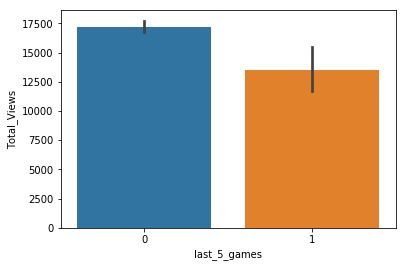

In [42]:
game_data['last_5_games'] = np.where(game_data['Total_games'] > 76, 1, 0)
training_data['last_5_games'] = game_data.loc[game_data['Location'] == 'H', ['last_5_games']]
sns.barplot(x = 'last_5_games', y = 'Total_Views', data = training_data)

In [43]:
randomforest(training_data)

[12.229372069258993, 32.63285331241714, 0.95112491842828673, 0.65261278822362623, 0.64081380236200791]


In [44]:
training_data.drop('last_5_games', axis = 1, inplace = True)

Adding past ranking in conference

In [45]:
rankinginconference = {'CLE': 1, 'NYK': 3, 'POR': 3,'UTA': 1, 'GSW': 1, 'SAS': 3, 'MIA': 3,
                     'ORL': 5, 'DAL': 5, 'IND': 3, 'BOS': 1, 'BKN': 5 , 'TOR': 2, 'DET': 5,
                     'MIL': 2, 'MEM': 3, 'NOP': 4, 'DEN': 4, 'PHI': 4, 'OKC': 2, 'PHX': 5, 
                     'SAC': 3, 'HOU': 2, 'LAL': 4, 'ATL': 2, 'WAS': 1, 'CHI': 4, 'LAC': 4,
                     'CHA': 4, 'MIN': 5 }


game_data['ranking'] = game_data['Team'].map(rankinginconference)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'last_5_games', 'ranking'],
      dtype='object')

In [46]:
training_data['home_ranking'] = game_data.loc[game_data['Location'] == 'H', ['ranking']]
training_data['away_ranking'] = game_data.loc[game_data['Location'] == 'A', ['ranking']]

In [47]:
randomforest(training_data)

[12.29494706116512, 32.660521642768842, 0.95307637447183735, 0.65705473467423192, 0.65422520461039124]


In [48]:
def xgboost(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    xgb = XGBRegressor(n_estimators=500)
    xgb.fit(train_X, train_y)
    res = [mape(xgb.predict(train_X), train_y), mape(xgb.predict(val_X), val_y), 
          xgb.score(train_X, train_y), xgb.score(val_X, val_y)]
    if hasattr(xgb, 'oob_score_'): res.append(xgb.oob_score_)
    print(res)

In [49]:
xgboost(training_data)

[19.65983529313355, 29.485117697738982, 0.91267101993455202, 0.7377015933095834]


In [50]:
X = training_data.copy()
y = X['Total_Views']
X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
rf = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [51]:
def print_score(m):
    res = [mape(m.predict(train_X), train_y), mape(m.predict(val_X), val_y), 
          m.score(train_X, train_y), m.score(val_X, val_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [52]:
print_score(rf)

[12.29494706116512, 32.660521642768842, 0.95307637447183735, 0.65705473467423192, 0.65422520461039124]


In [56]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [57]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                    ).sort_values('imp', ascending=False)

In [58]:
fi = rf_feat_importance(rf, train_X)

In [59]:
fi[:10]

,cols,imp
3,AllStar,0.353684
66,Total_games_home,0.164935
39,Away_Team_5,0.051938
9,Home_Team_5,0.035051
1,day of week,0.033678
69,away_ranking,0.024977
68,home_ranking,0.023142
24,Home_Team_20,0.021124
17,Home_Team_13,0.020642
0,Season,0.018890


According to this... All Stars is a pretty big factor in viewers. We should probably be looking at players instead of teams/dayofweek info. 

In [60]:
player_data.head()

,Season,Game_Date,Team,Person_ID,Name,ASG_Team,Active_Status,Minutes,Points,Defensive_Rebounds,...,Blocks,Turnovers,Field_Goals,Field_Goals_Attempted,Three_Pointers,Three_Pointers_Attempted,Free_Throws,Free_Throws_Attempted,Personal_Fouls,AllStar
Game_ID,,,,,,,,,,,,,,,,,,,,,
21600001,2016-17,10/25/2016,CLE,101112,Channing Frye,None,Active,14.0,6.0,2.0,...,1.0,1.0,2.0,6.0,2.0,5.0,0.0,0.0,4.0,0
21600001,2016-17,10/25/2016,CLE,201567,Kevin Love,East ASG,Active,25.0,23.0,10.0,...,0.0,2.0,6.0,15.0,2.0,6.0,9.0,12.0,3.0,1
21600001,2016-17,10/25/2016,CLE,202681,Kyrie Irving,East ASG,Active,30.0,29.0,1.0,...,0.0,0.0,12.0,22.0,4.0,7.0,1.0,1.0,1.0,1
21600001,2016-17,10/25/2016,CLE,202684,Tristan Thompson,None,Active,22.0,0.0,4.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0
21600001,2016-17,10/25/2016,CLE,202697,Iman Shumpert,None,Active,14.0,2.0,1.0,...,1.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,2.0,0


In [61]:
fi [:20]

,cols,imp
3,AllStar,0.353684
66,Total_games_home,0.164935
39,Away_Team_5,0.051938
9,Home_Team_5,0.035051
1,day of week,0.033678
69,away_ranking,0.024977
68,home_ranking,0.023142
24,Home_Team_20,0.021124
17,Home_Team_13,0.020642
0,Season,0.018890


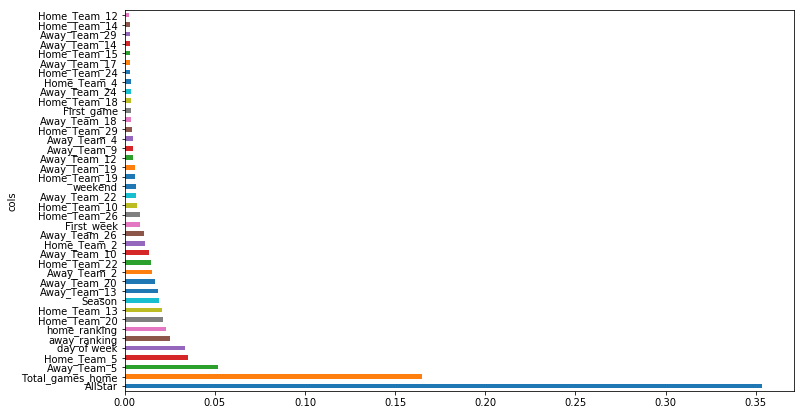

In [62]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:40]);

In [63]:
rf = RandomForestRegressor(random_state = 0, 
                                         n_estimators=300, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)
print_score(rf)

[12.247932942377444, 32.680791367531924, 0.95316711732869952, 0.65734292887894052, 0.65544404095848274]


In [64]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
to_keep

3              AllStar
66    Total_games_home
39         Away_Team_5
9          Home_Team_5
1          day of week
69        away_ranking
68        home_ranking
24        Home_Team_20
17        Home_Team_13
0               Season
47        Away_Team_13
54        Away_Team_20
36         Away_Team_2
26        Home_Team_22
44        Away_Team_10
6          Home_Team_2
60        Away_Team_26
65          First_week
30        Home_Team_26
14        Home_Team_10
56        Away_Team_22
2              weekend
23        Home_Team_19
53        Away_Team_19
Name: cols, dtype: object

In [65]:
X = training_data.copy()
y = X['Total_Views']
X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
rf = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [66]:
print_score(rf)

[12.29494706116512, 32.660521642768842, 0.95307637447183735, 0.65705473467423192, 0.65422520461039124]


First some data from https://www.statista.com/statistics/322941/facebook-fans-twitter-followers-of-nba/

In [67]:
nba_followers = {'CLE': 3.16, 'NYK': 2.07, 'POR': 1.13,'UTA': 0.79, 'GSW': 5.63, 'SAS': 3.32, 'MIA':  4.68,
                     'ORL': 1.59, 'DAL': 0.79, 'IND': 1.11, 'BOS': 3.21, 'BKN': 0.88, 'TOR': 1.5, 'DET': 0.85,
                     'MIL': 0.87, 'MEM': 0.92, 'NOP': 0.8, 'DEN': 0.79, 'PHI': 1.46, 'OKC': 2.55, 'PHX': 0.99, 
                     'SAC': 0.96, 'HOU': 2.54, 'LAL': 7.39, 'ATL': 1.19, 'WAS': 0.85, 'CHI': 4.09, 'LAC': 1.37,
                     'CHA': 0.88, 'MIN': 0.85 }


game_data['nba_followers'] = game_data['Team'].map(nba_followers)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'last_5_games', 'ranking', 'nba_followers'],
      dtype='object')

In [68]:
training_data['nba_followers'] = game_data.groupby('Game_ID')['nba_followers'].sum()

In [69]:
training_data.head()

,Season,Game_Date,day of week,weekend,Total_Views,AllStar,Home_Team_0,Home_Team_1,Home_Team_2,Home_Team_3,...,Away_Team_27,Away_Team_28,Away_Team_29,First_game,First_week,Total_games_home,Total_games_away,home_ranking,away_ranking,nba_followers
Game_ID,,,,,,,,,,,,,,,,,,,,,
21600001,0,2016-10-25,1,0,57691,4,0,0,0,0,...,0,0,0,1,1,0,1,1,3,5.23
21600003,0,2016-10-25,1,0,60428,5,0,0,0,0,...,0,0,0,1,1,0,1,1,3,8.95
21600002,0,2016-10-25,1,0,40740,1,0,0,0,0,...,0,1,0,1,1,0,1,3,1,1.92
21600006,0,2016-10-26,2,0,23947,1,0,0,1,0,...,0,0,0,1,1,0,1,1,5,4.09
21600008,0,2016-10-26,2,0,12046,2,0,0,0,0,...,0,0,0,1,1,0,1,2,4,1.75


c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


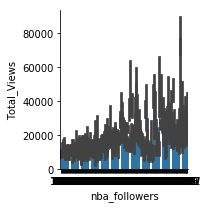

In [70]:
g = sns.FacetGrid(training_data)
g.map(sns.barplot, 'nba_followers',  'Total_Views')

In [71]:
X = training_data.copy()
y = X['Total_Views']
X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
rf = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [72]:
print_score(rf)

[12.225204833196678, 32.881998078566582, 0.9562834105158049, 0.67585823829689673, 0.68022668172787482]


In [73]:
fi = rf_feat_importance(rf, train_X); fi[:10]

,cols,imp
3,AllStar,0.327364
70,nba_followers,0.237708
66,Total_games_home,0.169147
1,day of week,0.026838
39,Away_Team_5,0.022374
9,Home_Team_5,0.015667
68,home_ranking,0.014876
69,away_ranking,0.014707
0,Season,0.013662
26,Home_Team_22,0.013328


It didn't really help our model but it nba_followers is the 2nd more important feature...

In [74]:
xgboost(training_data)

[18.572538441995821, 29.656718037013167, 0.91972649385995831, 0.73440225822286187]


Xgboost with 500 estimators or rounds has a mape of 29.65 which is the best so far. It still seems to overfit a bit however. Next we will try adding player twitter data

In [75]:
names = player_data.Name.unique()

In [76]:
names

array(['Channing Frye', 'Kevin Love', 'Kyrie Irving', 'Tristan Thompson',
       'Iman Shumpert', 'DeAndre Liggins', 'Jordan McRae', 'Kay Felder',
       'JR Smith', 'Mike Dunleavy', 'LeBron James', 'Mo Williams',
       'James Jones', 'Richard Jefferson', 'Chris Andersen',
       'Marshall Plumlee', 'Mindaugas Kuzminskas', 'Maurice Ndour',
       'Ron Baker', 'Justin Holiday', 'Kristaps Porzingis', 'Lance Thomas',
       'Courtney Lee', 'Brandon Jennings', "Kyle O'Quinn",
       'Willy Hernangomez', 'Sasha Vujacic', 'Carmelo Anthony',
       'Derrick Rose', 'Joakim Noah', 'Maurice Harkless', 'Damian Lillard',
       'Al-Farouq Aminu', 'Evan Turner', 'Festus Ezeli', 'CJ McCollum',
       'Allen Crabbe', 'Mason Plumlee', 'Meyers Leonard', 'Shabazz Napier',
       'Pat Connaughton', 'Ed Davis', 'Tim Quarterman', 'Noah Vonleh',
       'Jake Layman', 'Gordon Hayward', 'Alec Burks', 'Raul Neto',
       'Joel Bolomboy', 'Shelvin Mack', 'Jeff Withey', 'Rudy Gobert',
       'Rodney Hood', 'Joe